In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

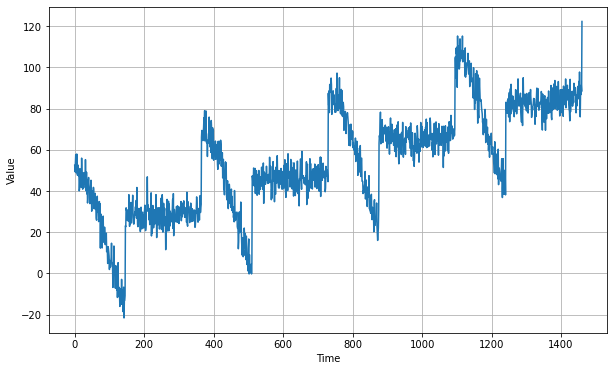

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4, 
                   np.cos(season_time * 2 * np.pi), 
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_label=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
sereis = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [22]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 0s 2ms/step - loss: 142.9073
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 84.3096
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 80.8075
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 79.7972
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 75.5052
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 75.9015
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 75.7609
Epoch 8/100
46/46 [==============================] - 0s 2ms/step - loss: 69.1683
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 67.7469
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 67.1655
Epoch 11/100
46/46 [==============================] - 0s 2ms/step - loss: 65.1774
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 63.5212
Epoch 13/100
46/46 [====

In [23]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.00929364],
       [-0.05377866],
       [ 0.02839262],
       [-0.01780233],
       [ 0.02767531],
       [-0.02801803],
       [ 0.00136557],
       [-0.01343072],
       [ 0.00175459],
       [ 0.01837954],
       [-0.01058664],
       [ 0.03321793],
       [-0.03010833],
       [ 0.0296966 ],
       [-0.01471809],
       [ 0.07155655],
       [ 0.03275049],
       [ 0.18992418],
       [ 0.26456547],
       [ 0.43295297]], dtype=float32), array([0.0150377], dtype=float32)]


In [24]:
print(series[1:21])
model.predict(series[1:21][np.newaxis])

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[47.57256]], dtype=float32)

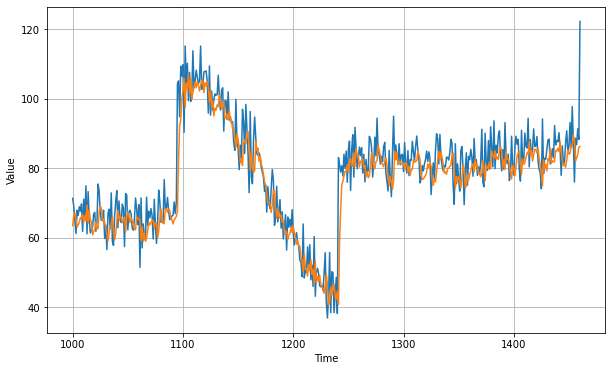

In [26]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis ]))
    
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.068155